In [11]:
# Importing Liabraries and Monai Libraries
import os
import shutil
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from monai.utils import first, set_determinism
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    ScaleIntensityRanged,

)
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    Dataset,
)


import torch

print_config()

MONAI version: 1.3.1
Numpy version: 1.26.3
Pytorch version: 2.2.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.0.1
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.17.0
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.14.1
pynrrd version: 1.0.0
clearml version: 1.16.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [12]:
#Define and create folder if Not Exist
directory = "/workspace/SpineSegmentationProject/"
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/SpineSegmentationProject/


In [13]:
#Combine multiple transformers to one pipline
train_transforms = Compose(
    [
        #Load image and label from file
        LoadImaged(keys=["image", "label"]),

        #Ensures that the channel dimension is the first dimension for both the image and label
        EnsureChannelFirstd(keys=["image", "label"]),

        #Uniform orientation of all images in PSR or RSP way, we used PSR
        # since we already did this manually in preprocessing it is commented
        #Orientationd(keys=["image", "label"], axcodes="PSR"),

        #Scales the intensity values of the image to a specified range
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000,   #min value to scale from
            a_max=3096,    #max value to scale from
            b_min=0.0,     #min value to scale to
            b_max=1.0,     #max value to scale to
            clip=True,     #clip values outside of range
        ),
        

    ]
)

In [14]:
#Define data direcory and json file
data_dir = "/workspace/SpineSegmentationProject/"
split_json = "spider_dataset.json"

#split data training and validation
datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")

#Define cahced Dataset 
train_ds = CacheDataset(
    data=datalist,                            #asssign datas set
    transform=train_transforms,               #assign transform
    cache_num=24,                             #No. of items to be cached
    cache_rate=1.0,                           #1.0 means all item to be cached
    num_workers=8,                            #No. of worker threads
)
#DataLoader for the training dataset
train_loader = DataLoader(train_ds, batch_size=18, shuffle=True, num_workers=8, pin_memory=True)

#Creates a cached dataset for validation
val_ds = CacheDataset(data=val_files, transform=train_transforms, cache_num=6, cache_rate=1.0, num_workers=4)

#DataLoader for the Validation dataset
val_loader = DataLoader(val_ds, batch_size=6, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:00<00:00, 75.72it/s]


image shape: torch.Size([1, 32, 128, 128]), label shape: torch.Size([1, 32, 128, 128])


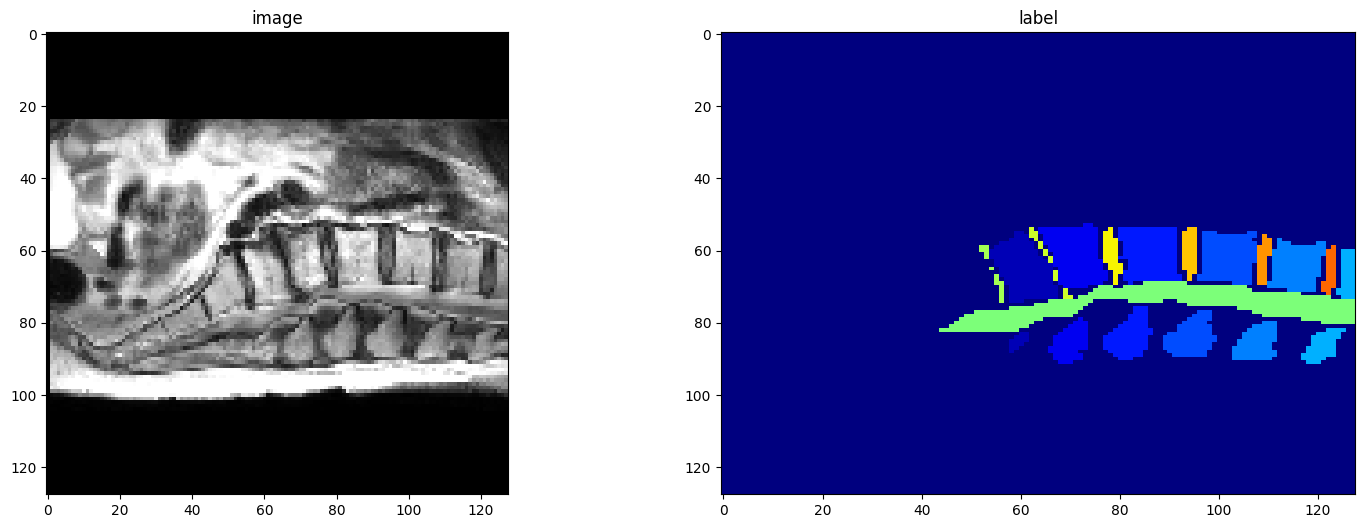

In [15]:
#Visualizing specific slice from input data
slice_map = {
    "245_t2.mha": 16,
    "245_t2.mha": 16,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, slice_map[img_name], :, :].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, slice_map[img_name], :, :],vmin=0, vmax=20, cmap='jet', aspect='auto')
plt.show()

In [16]:
#Check the shape of input data after preprocessing and blending image with mask
check_ds = Dataset(data=datalist, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

ret = blend_images(image=check_data["image"][0], label=check_data["label"][0], alpha=0.5, cmap="jet", rescale_arrays=True)
print(ret.shape)

torch.Size([3, 32, 128, 128])


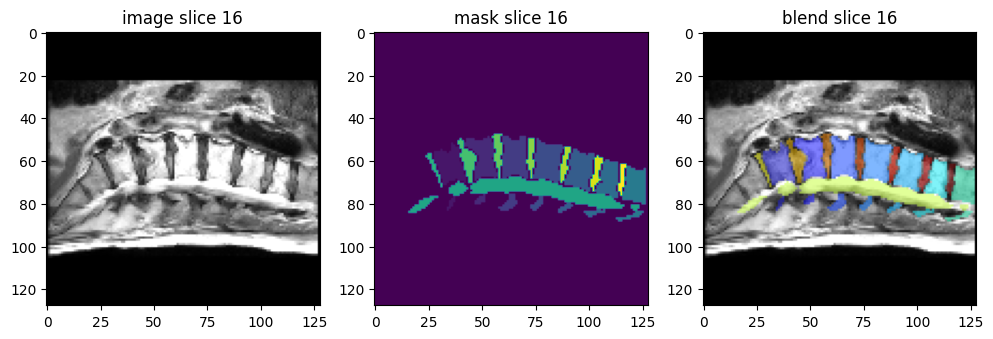

In [17]:
slice_index = 16
plt.figure("blend image and mask", (12, 4))
plt.subplot(1, 3, 1)
plt.title(f"image slice {slice_index}")
plt.imshow(check_data["image"][0, 0, slice_index, :, :], cmap="gray")
plt.subplot(1, 3, 2)
plt.title(f"mask slice {slice_index}")
plt.imshow(check_data["label"][0, 0, slice_index, :, :])
plt.subplot(1, 3, 3)
plt.title(f"blend slice {slice_index}")
    # switch the channel dim to the last dim
plt.imshow(torch.moveaxis(ret[:, slice_index, :, :], 0, -1))
plt.show()

In [18]:
#setting the device to use GPU and if not available use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')

#Define UNETR Model
model = UNETR(
    in_channels=1,                       #No. of input channel, 1 for greyscale images
    out_channels=20,                     #No. of output channels, 20 classes for segmentation
    img_size=(32, 128, 128),             #size of input image
    feature_size=16,                     #Feature size of the convolutional layers
    hidden_size=768,                     #Hidden size of the transformer layers
    mlp_dim=3072,                        #Dimension of the MLP layers in the transformer
    num_heads=12,                        #Number of attention heads in the transformer
    #pos_embed="perceptron",             
    norm_name="instance",                #Type of normalization used (instance normalization)
    res_block=True,                      #Use of residual blocks
    dropout_rate=0.0,                    #Dropout rate for regularization
).to(device)

#Using DiceCELoss combination of Dice loss and Cross-Entropy loss, using one hot encoding and soft max
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True

#Using AdamW optimizer which includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [19]:
def validation(epoch_iterator_val):
    """
    Evaluates the model on the validation dataset and computes the mean Dice score.

    Args:
        epoch_iterator_val (iterable): Iterator for the validation dataset.

    Returns:
        float: The mean Dice score for the validation dataset.
    """
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (32, 128, 128), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


# Define training function
def train(global_step, train_loader, dice_val_best, global_step_best):
    """
    Trains the model for one epoch and evaluates it periodically.
    
    Args:
        global_step (int): The current global step count.
        train_loader (DataLoader): DataLoader for the training dataset.
        dice_val_best (float): The best Dice validation score achieved so far.
        global_step_best (int): The global step at which the best Dice score was achieved.
    
    Returns:
        tuple: Updated global step, best Dice validation score, and global step at which the best score was achieved.
    """
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))

        # Debug: Print unique values in the label tensor
        #unique_vals = torch.unique(y)
        #print(f"Unique label values: {unique_vals}")

        # Clamp the label values to the valid range
        y = torch.clamp(y, 0, 19)

        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                print("Model Was Saved! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
            else:
                print("Model Not Saved! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 21000                              #Total number of training iterations
eval_num = 1000                                     #Number of iterations between evaluations
post_label = AsDiscrete(to_onehot=20)               #Transformation to convert labels to one-hot encoding
post_pred = AsDiscrete(argmax=True, to_onehot=20)   #Transformation to apply argmax and convert predictions to one-hot encoding
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)  #Metric for computing the Dice score
global_step = 0                                     #Initial global step
dice_val_best = 0.0                                 #Best Dice validation score achieved so far
global_step_best = 0                                #Global step at which the best Dice score was achieved
epoch_loss_values = []                              #List to store loss values for each epoch
metric_values = []                                  #List to store metric values for each evaluation


In [20]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Validate (1000 / 10 Steps): 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Model Was Saved! Current Best Avg. Dice: 0.0 Current Avg. Dice: 0.202234148979187


Validate (2000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


Model Was Saved! Current Best Avg. Dice: 0.202234148979187 Current Avg. Dice: 0.3394359052181244


Validate (3000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]


Model Was Saved! Current Best Avg. Dice: 0.3394359052181244 Current Avg. Dice: 0.43685510754585266


Validate (4000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]


Model Was Saved! Current Best Avg. Dice: 0.43685510754585266 Current Avg. Dice: 0.5227579474449158


Validate (5000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]


Model Was Saved! Current Best Avg. Dice: 0.5227579474449158 Current Avg. Dice: 0.5706666111946106


Validate (6000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]


Model Was Saved! Current Best Avg. Dice: 0.5706666111946106 Current Avg. Dice: 0.6742911338806152


Validate (7000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]


Model Was Saved! Current Best Avg. Dice: 0.6742911338806152 Current Avg. Dice: 0.6766781806945801


Validate (8000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]


Model Was Saved! Current Best Avg. Dice: 0.6766781806945801 Current Avg. Dice: 0.6809961199760437


Validate (9000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


Model Was Saved! Current Best Avg. Dice: 0.6809961199760437 Current Avg. Dice: 0.6850374341011047


Validate (10000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]


Model Was Saved! Current Best Avg. Dice: 0.6850374341011047 Current Avg. Dice: 0.6877634525299072


Validate (11000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


Model Was Saved! Current Best Avg. Dice: 0.6877634525299072 Current Avg. Dice: 0.6961472630500793


Validate (12000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


Model Was Saved! Current Best Avg. Dice: 0.6961472630500793 Current Avg. Dice: 0.6981222033500671


Validate (13000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.95it/s]


Model Was Saved! Current Best Avg. Dice: 0.6981222033500671 Current Avg. Dice: 0.7043619155883789


Validate (14000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


Model Was Saved! Current Best Avg. Dice: 0.7043619155883789 Current Avg. Dice: 0.7055009007453918


Validate (15000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]


Model Was Saved! Current Best Avg. Dice: 0.7055009007453918 Current Avg. Dice: 0.7055771946907043


Validate (16000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]


Model Was Saved! Current Best Avg. Dice: 0.7055771946907043 Current Avg. Dice: 0.7113890051841736


Validate (17000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


Model Was Saved! Current Best Avg. Dice: 0.7113890051841736 Current Avg. Dice: 0.7138074040412903


Training (18000 / 21000 Steps) (loss=0.22583):   5%|▌         | 1/20 [00:03<01:03,  3.36s/it]

Model Not Saved! Current Best Avg. Dice: 0.7138074040412903 Current Avg. Dice: 0.7049943804740906


Validate (19000 / 10 Steps): 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]


Model Was Saved! Current Best Avg. Dice: 0.7138074040412903 Current Avg. Dice: 0.7154036164283752


Training (20000 / 21000 Steps) (loss=0.16990):   5%|▌         | 1/20 [00:03<01:03,  3.33s/it]

Model Not Saved! Current Best Avg. Dice: 0.7154036164283752 Current Avg. Dice: 0.7116090655326843


Training (20999 / 21000 Steps) (loss=0.22423): 100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


<All keys matched successfully>

In [21]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7154 at iteration: 19000


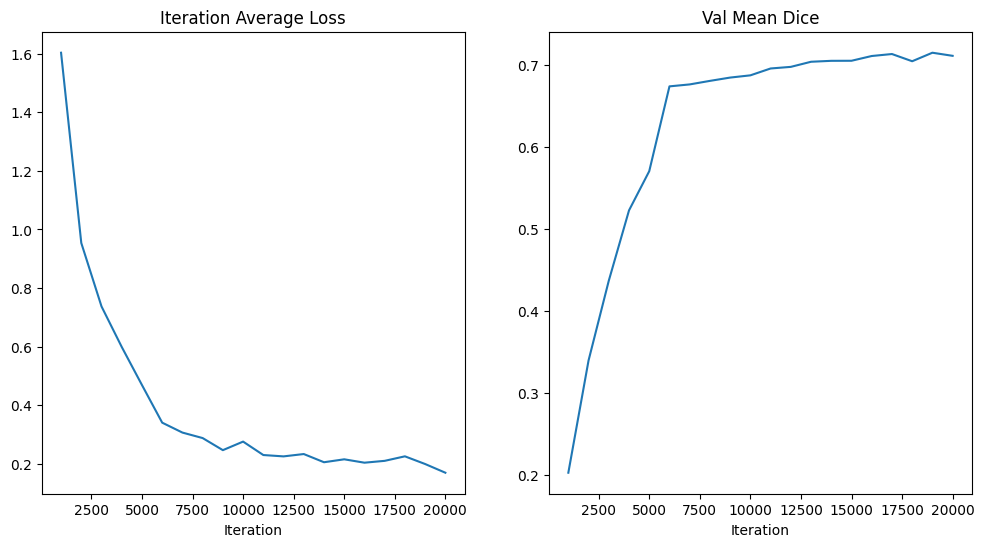

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

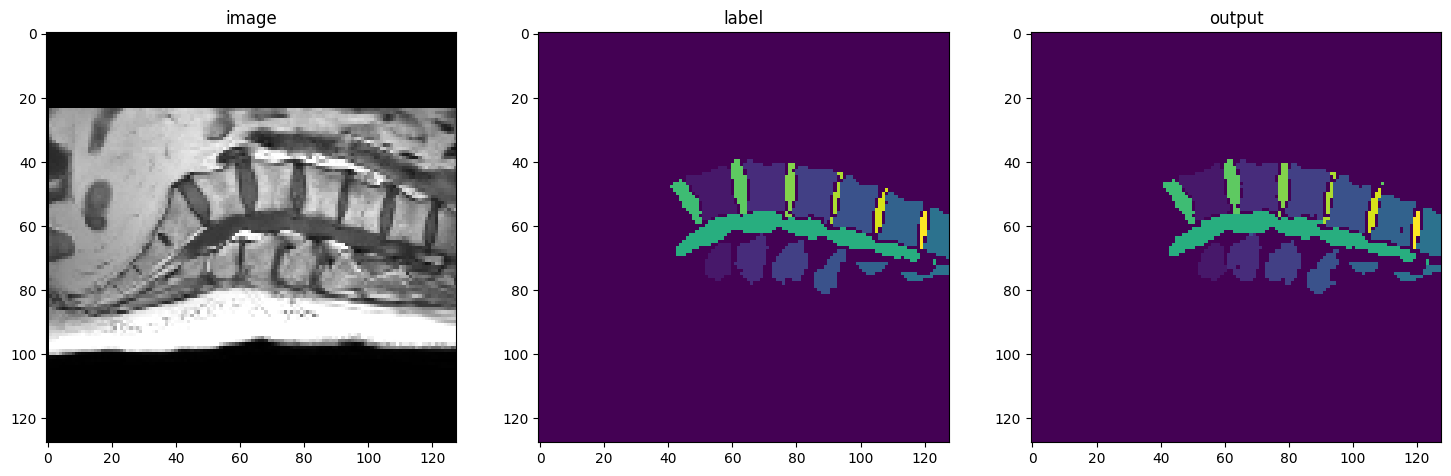

In [23]:
# Specify the case number from the validation set to be visualized
case_num = 2

# Load the best model weights saved during training
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Extract the filename of the image
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    
    # Retrieve the image and label tensors for the specified case
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    
    # Add an additional dimension to the tensors and move them to the specified device (GPU or CPU)
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    
    # Perform sliding window inference on the input image to generate predictions
    val_outputs = sliding_window_inference(val_inputs, (32, 128, 128), 4, model, overlap=0.8)
    
    # Create a new figure for visualization
    plt.figure("check", (18, 6))
    
    # Display the input image slice
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, slice_index, :, :], cmap="gray")
    
    # Display the ground truth label slice
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, slice_index, :, :])
    
    # Display the model's predicted output slice
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, slice_index, :, :])
    
    # Show the visualization
    plt.show()
